In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

# Loads a data file from a provided file location.
def load_data(path):
    return pd.read_csv(path)

# Implements dataset preprocessing, with boolean options to either normalize the data or not, 
# and to either drop the sqrt_living15 column or not.
#
# Note that you will call this function multiple times to generate dataset versions that are
# / aren't normalized, or versions that have / lack sqrt_living15.
def preprocess_data(data, normalize, drop_sqrt_living15):
    # Drop ID column
    preprocessed_data = data
    preprocessed_data = preprocessed_data.drop(columns=["id"])
    
    # Split date into month, day, and year
    preprocessed_data['month'] = [int(x.split("/")[0]) for x in preprocessed_data['date'].values] # month
    preprocessed_data['day'] = [int(x.split("/")[1]) for x in preprocessed_data['date'].values] # day
    preprocessed_data['year'] = [int(x.split("/")[2]) for x in preprocessed_data['date'].values] # year
    preprocessed_data = preprocessed_data.drop(columns=["date"])
    
    # Insert bias term (weight 0)
    preprocessed_data.insert(loc=0, column="bias", value=1)
    
    # Generate new feature based on year, year built, and year renovated
    preprocessed_data['age_since_renovated'] = preprocessed_data.apply(lambda d: ((d["year"] - d["yr_built"]) if 
                                                                                  (d["yr_renovated"] == 0) else 
                                                                                  (d["year"] - d["yr_renovated"])), axis=1)
    preprocessed_data = preprocessed_data.drop(columns=["yr_renovated"])
    
    # Generate mu and sigma for training data (also used in test data)
    if len(mu_dict) == 0:
        for col in preprocessed_data.columns.values:
            if col not in ['bias', 'price', 'waterfront']:
                mu_dict[col] = preprocessed_data[col].mean()
                sigma_dict[col] = preprocessed_data[col].std()
        
    # Normalize columns if flagged
    if normalize:
        for column in preprocessed_data: 
            if column not in ['bias', 'waterfront', 'price']:
                preprocessed_data[column] = ((preprocessed_data[column] - mu_dict[column])/sigma_dict[column])
    
    # Drop sqft_living 15 if flagged
    if drop_sqrt_living15:
        preprocessed_data = preprocessed_data.drop(columns=["sqft_living15"])
                
    return preprocessed_data

# Implements the feature engineering required for part 4. Quite similar to preprocess_data.
# Expand the arguments of this function however you like to control which feature modification
# approaches are / aren't active.
def modify_features(data):
    # Your code here:

    return modified_data

# Trains a linear model on the provided data and labels, using the supplied learning rate.
# weights should store the per-feature weights of the learned linear regression.
# losses should store the sequence of MSE losses for each epoch of training, which you will then plot.
def gd_train(data, labels, lr):
    n_iterations = 4000
    n = len(data)
    n_features = len(data.columns.values)
    epsilonLow = 10**(-2) # converged values
    epsilonHigh = 10**7 # diverged value
    
    w_init = np.zeros(n_features).reshape(n_features,1)
    weights = w_init
    losses = []
    
    print("Learning Rate: ", lr) # DELETE
    for iter in range(n_iterations):
        # Rename the product to match y label
        y_hat = (data.dot(weights)).rename(columns={0: "price"})

        grads = 2/n * data.T.dot(y_hat - labels)
        weights = weights - lr * grads

        y_pred = (data.dot(weights)).rename(columns={0: "prices"})
        mse = float(((labels - y_pred) ** 2).sum() / n)
        losses.append(mse)

        magLw = np.linalg.norm(grads.values) # magnitude of gradient (change in weights)

        # Early stop due to tiny change or diverging
        if magLw < epsilonLow:
            print("Converged Early, iter: ", iter) # DELETE
            diverged[str(lr)] = False
            return weights, losses

        if magLw > epsilonHigh:
            print("Diverged, iter: ", iter) # DELETE
            diverged[str(lr)] = True
            return weights, losses
    
    diverged[str(lr)] = False
    return weights, losses

# Generates and saves plots of the training loss curves. Note that you can interpret losses as a matrix
# containing the losses of multiple training runs and then put multiple loss curves in a single plot.
def plot_losses(losses):
    plt.figure(figsize=(14,8))
    for i, (lr, mse) in enumerate(losses.items()):
        if not diverged[lr]: # dont plot diverging models
            plt.plot(np.arange(1,len(mse)+1), mse, label=lr, linewidth=3)

    plt.legend(title="LR")   
    plt.xlabel("Iterations")
    plt.ylabel("MSE")
    plt.title("MSE per Iteration by Learning Rates (Figure 1)")
    plt.savefig("MSE_per_LR.jpg")

    return


In [7]:
# Invoke the above functions to implement the required functionality for each part of the assignment.

# Part 0  : Data preprocessing.
train_raw = load_data("IA1_train.csv") # load train data
val_raw = load_data("IA1_dev.csv") # load test data
mu_dict = {} # dict for training feature mu's
sigma_dict = {} # dict for training sigma mu's
train_ppd = preprocess_data(train_raw, True, False) # preprocess train (normalized)
val_ppd = preprocess_data(val_raw, True, False) # preprocess test (normalized)

In [25]:
# Part 1 . Implement batch gradient descent and experiment with different learning rates.
features = train_ppd.columns.drop("price")
X_train = train_ppd[features]
y_train = train_ppd["price"].to_frame()
X_val = val_ppd[features]
y_val = val_ppd["price"].to_frame()

mse_lr = {}
w_lr = {}
diverged = {}

learning_rates = [1, 0.178, 0.15, 0.1, 0.05, 0.01, 0.001, 0.0001]
for lr in learning_rates:
    wghts, loss = gd_train(X_train, y_train, lr)
    mse_lr[str(lr)] = loss
    w_lr[str(lr)] = wghts

Learning Rate:  1
Diverge, iter:  6
Learning Rate:  0.178
Converge, iter:  1356
Learning Rate:  0.15
Converge, iter:  882
Learning Rate:  0.1
Converge, iter:  1323
Learning Rate:  0.05
Converge, iter:  2646
Learning Rate:  0.01
Learning Rate:  0.001
Learning Rate:  0.0001


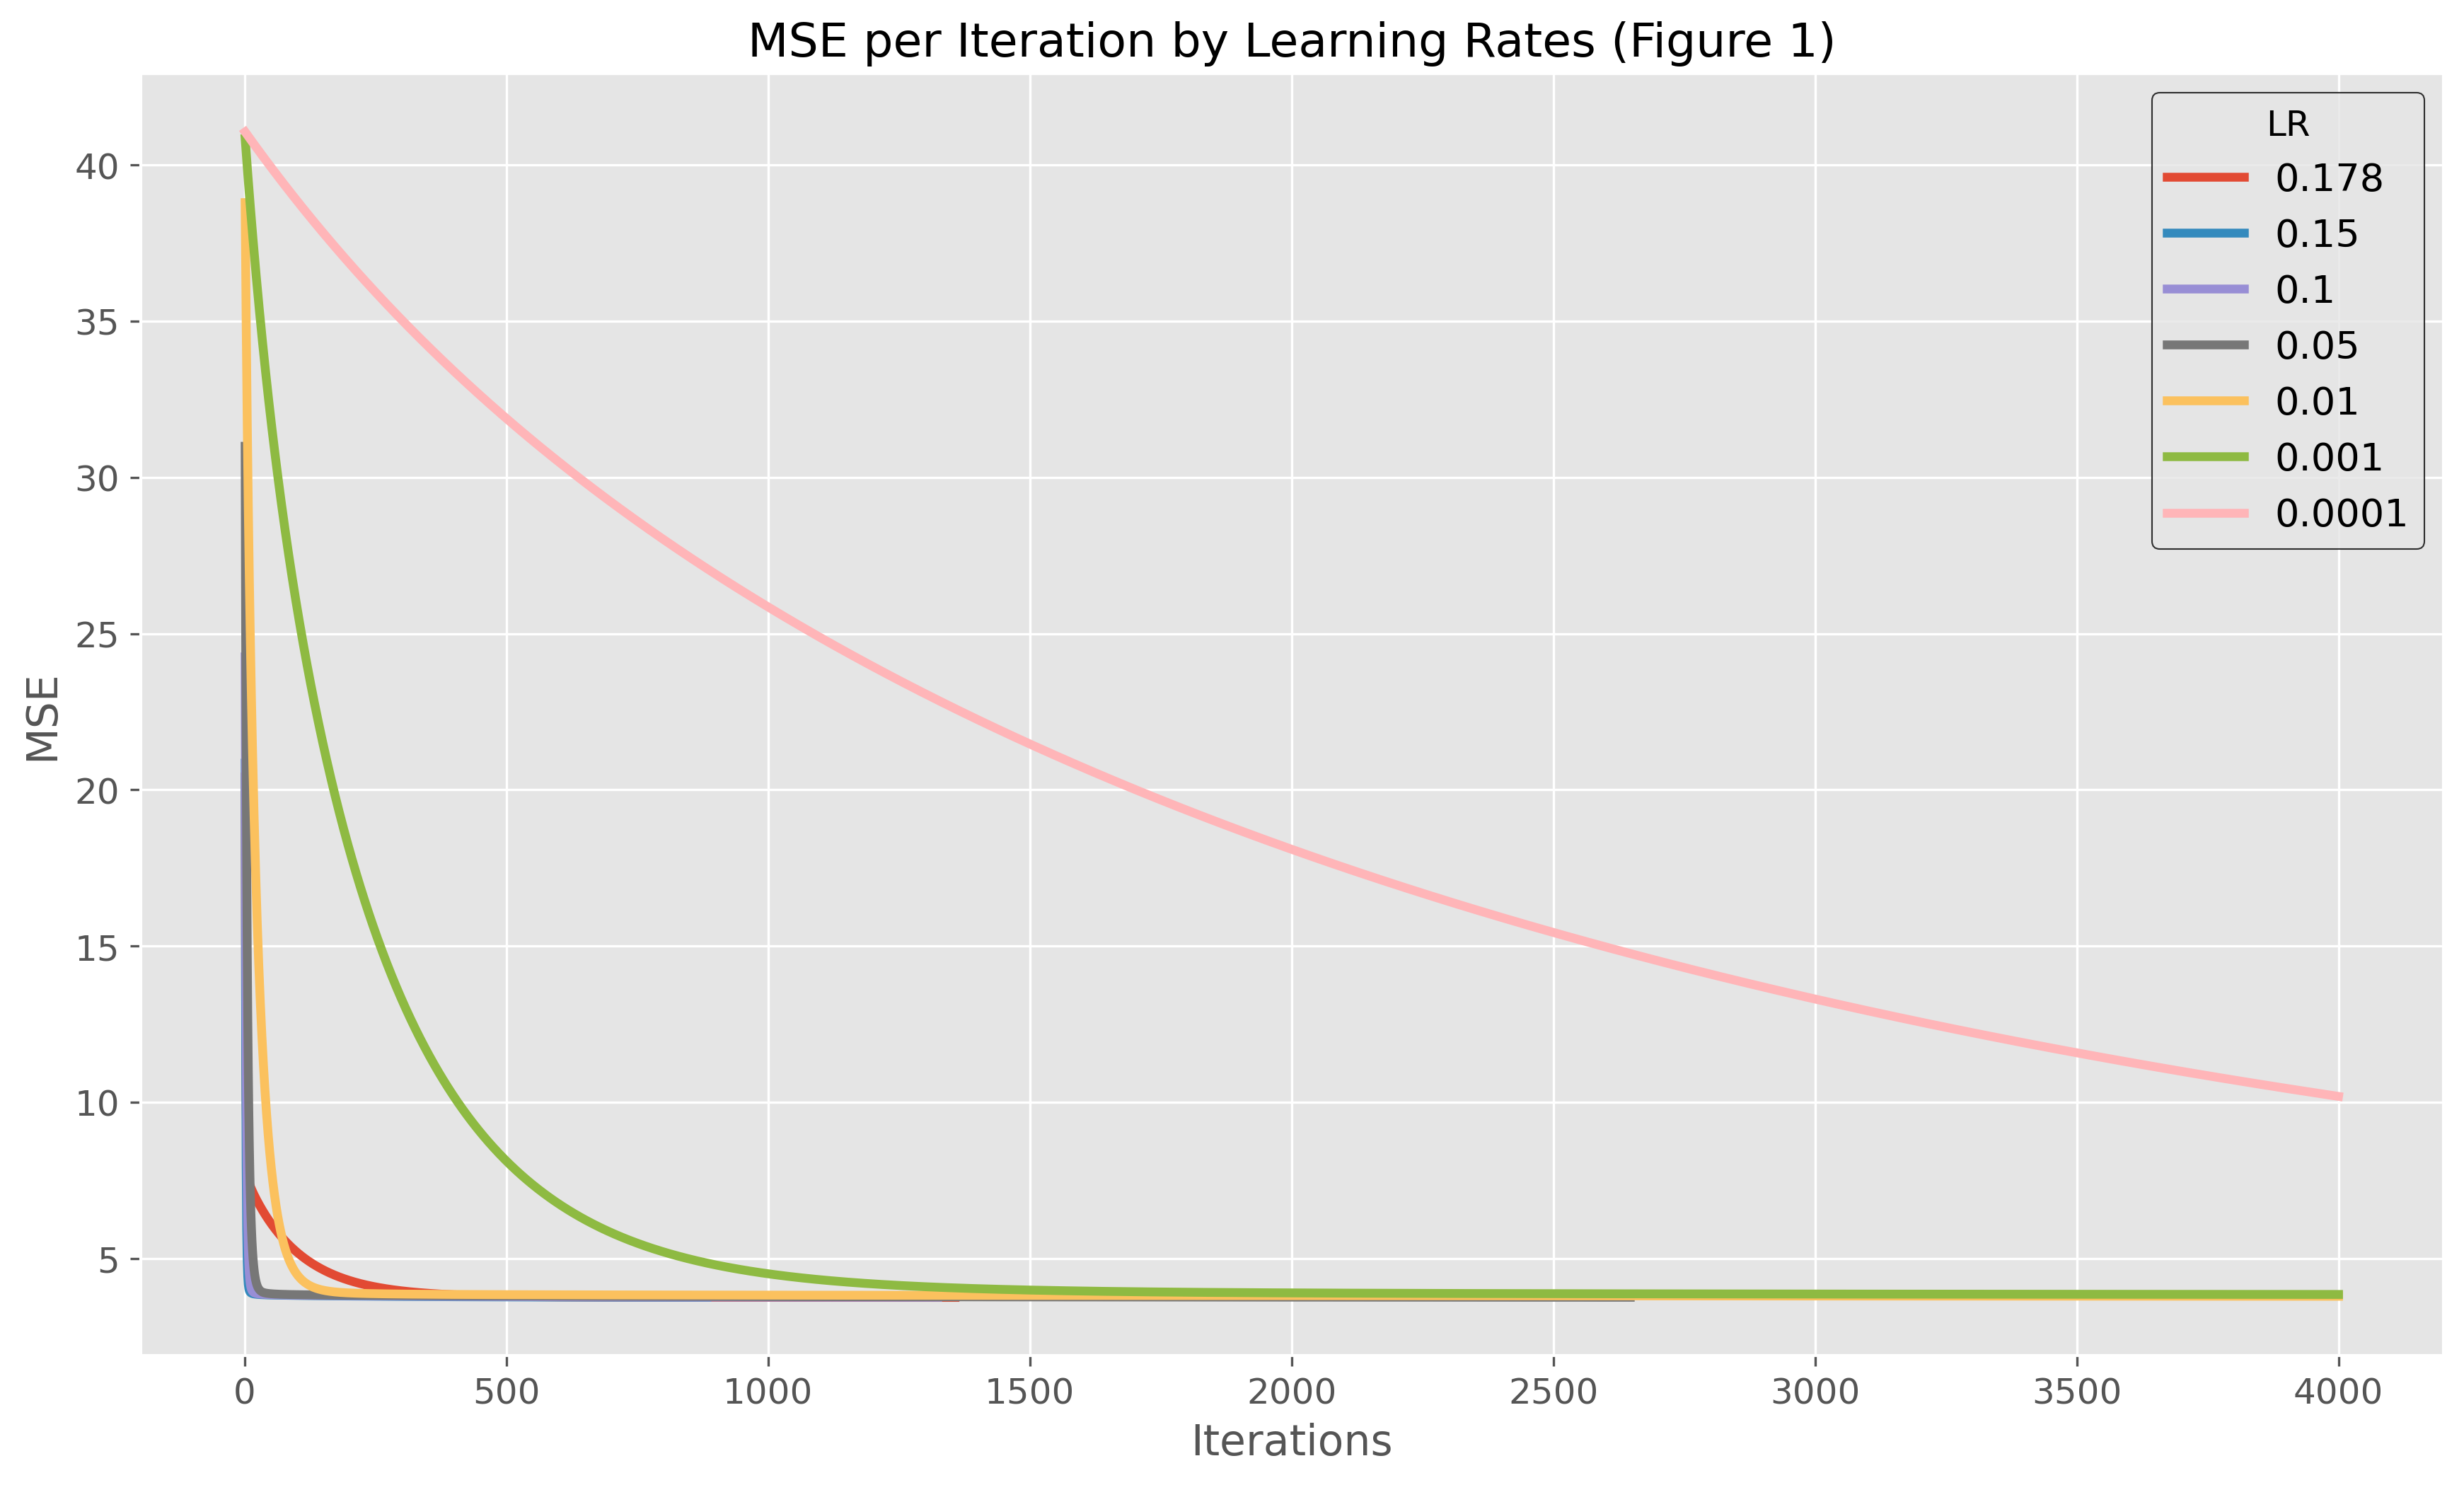

In [45]:
plot_losses(mse_lr)

In [40]:
cur_min = 1000000
best_model = " "
n = len(y_val)
print("Learning Rates and MSE\n")
for lr, w in w_lr.items():
    if not diverged[lr]:
        y_pred = (X_val.dot(w)).rename(columns={0: "prices"})
        mse = float(((y_val - y_pred) ** 2).sum() / n)
        print("Learning Rate:", lr + ", MSE:", mse)
        if mse < cur_min:
            cur_min = mse
            best_model = lr

Learning Rates and MSE

Learning Rate: 0.178, MSE: 4.514410129284036
Learning Rate: 0.15, MSE: 4.54678524916345
Learning Rate: 0.1, MSE: 4.546833362933282
Learning Rate: 0.05, MSE: 4.546881503414793
Learning Rate: 0.01, MSE: 4.654236187777755
Learning Rate: 0.001, MSE: 4.772455431334468
Learning Rate: 0.0001, MSE: 11.492099026803702


In [43]:
print("\nBest model has a learning rate of: ", best_model, ", with feature importance below:\n")
feat_importance = w_lr[best_model].rename(columns={"price":"weights"}).drop(index="bias")
for i, idx in enumerate(feat_importance.index.values):
    print(idx + ":", feat_importance.iloc[i].values[0])


Best model has a learning rate of:  0.178 , with feature importance below:

bedrooms: -0.28190992681497246
bathrooms: 0.33907116798005715
sqft_living: 0.7645263413159907
sqft_lot: 0.05845448333428845
floors: 0.01838203477334116
waterfront: 3.75252225440418
view: 0.4552178445795579
condition: 0.19993507901012583
grade: 1.113927607973986
sqft_above: 0.7580876588467802
sqft_basement: 0.15424196887745004
yr_built: -0.8837531020446169
zipcode: -0.2636471440026714
lat: 0.8364376491639488
long: -0.3041275140408903
sqft_living15: 0.14331210090571514
sqft_lot15: -0.09936815794511115
month: 0.05539696840138991
day: -0.05040859803125344
year: 0.17392041257858834
age_since_renovated: -0.10335159573251901


In [ ]:
# Part 2 a. Training and experimenting with non-normalized data.
